In [1]:
# Install dependencies
!pip install yfinance tensorflow scikit-learn matplotlib seaborn


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [3]:
# Example: Apple stock (AAPL) from 2015 to 2023
df = yf.download("AAPL", start="2015-01-01", end="2023-12-31")

print(df.head())


/tmp/ipython-input-371115051.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2015-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261057  24.729280  23.821681  24.718184  212818400
2015-01-05  23.577574  24.110150  23.391173  24.030263  257142000
2015-01-06  23.579794  23.839424  23.218085  23.641928  263188400
2015-01-07  23.910435  24.010292  23.677432  23.788385  160423600
2015-01-08  24.829124  24.886821  24.121242  24.238854  237458000


In [4]:
# Keep only required features
data = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Features and target
X = data[['Open', 'High', 'Low', 'Volume']]
y = data['Close']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scaling for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print("Training samples:", X_train.shape)


Training samples: (1811, 4)


Linear Regression R²: 0.9974385574136421
MSE: 0.8775151443766195


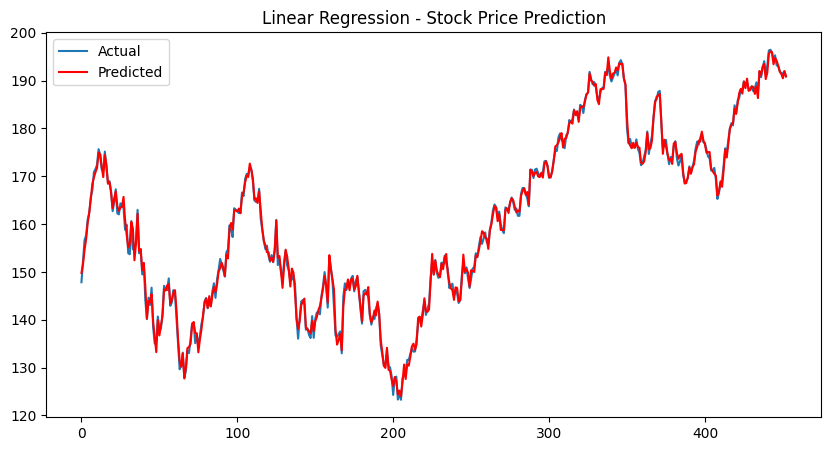

In [5]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)

# Evaluate
print("Linear Regression R²:", r2_score(y_test, y_pred_lr))
print("MSE:", mean_squared_error(y_test, y_pred_lr))

# Plot
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred_lr, label="Predicted", color="red")
plt.title("Linear Regression - Stock Price Prediction")
plt.legend()
plt.show()


Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 127ms/step - loss: 0.0255 - val_loss: 0.0028
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0016 - val_loss: 0.0045
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0011 - val_loss: 0.0071
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.0011 - val_loss: 0.0018
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


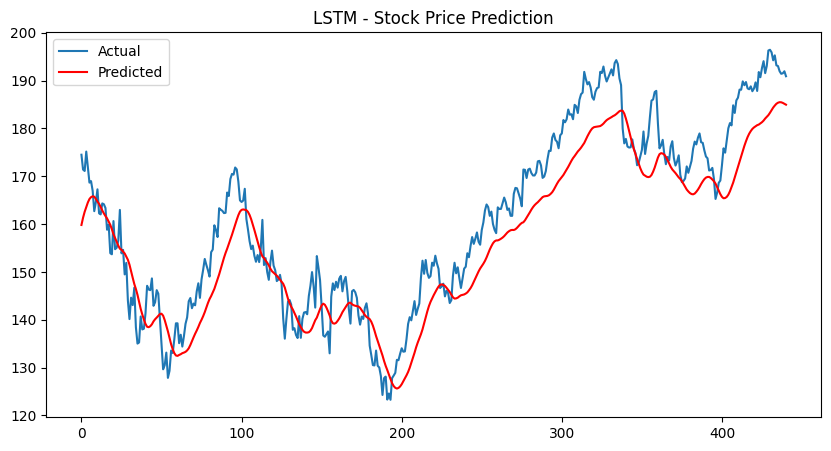

In [6]:
# Use only 'Close' price for LSTM
close_data = data[['Close']].values
scaler_lstm = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler_lstm.fit_transform(close_data)

# Sequence creation
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 60
X_lstm, y_lstm = create_sequences(scaled_close, SEQ_LEN)

# Train-test split
split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

# Build LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LEN,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

# Predictions
y_pred_lstm = model.predict(X_test_lstm)
y_pred_lstm = scaler_lstm.inverse_transform(y_pred_lstm)
y_test_lstm = scaler_lstm.inverse_transform(y_test_lstm)

# Plot
plt.figure(figsize=(10,5))
plt.plot(y_test_lstm, label="Actual")
plt.plot(y_pred_lstm, label="Predicted", color="red")
plt.title("LSTM - Stock Price Prediction")
plt.legend()
plt.show()


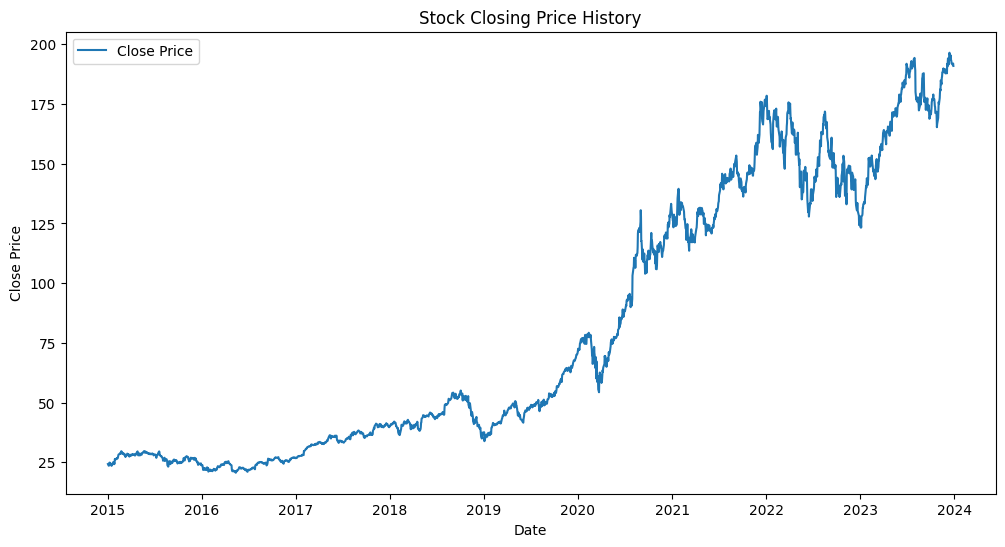

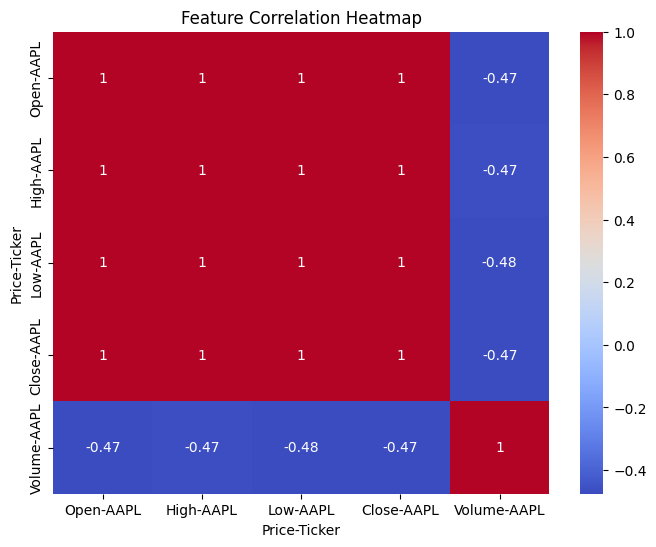

In [7]:
# Closing price history
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price')
plt.title("Stock Closing Price History")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()


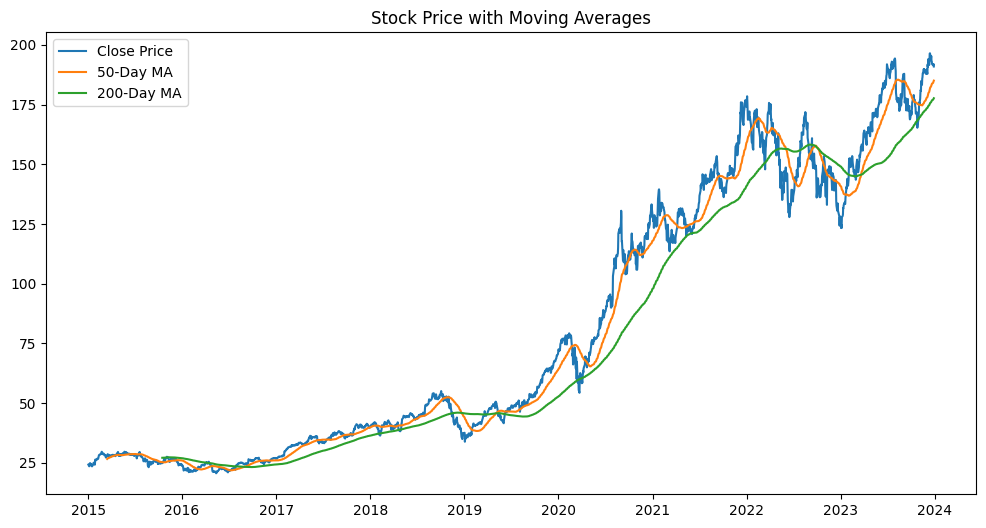

In [8]:
df['MA50'] = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()

plt.figure(figsize=(12,6))
plt.plot(df['Close'], label="Close Price")
plt.plot(df['MA50'], label="50-Day MA")
plt.plot(df['MA200'], label="200-Day MA")
plt.legend()
plt.title("Stock Price with Moving Averages")
plt.show()


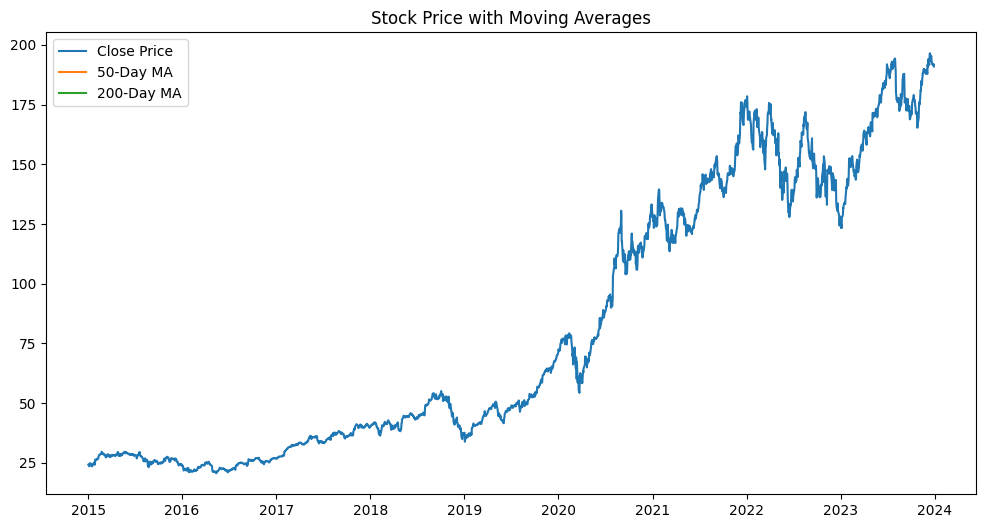

In [9]:
df['MA50'] = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()

plt.figure(figsize=(12,6))
plt.plot(df['Close'], label="Close Price")
plt.plot(df['MA50'], label="50-Day MA")
plt.plot(df['MA200'], label="200-Day MA")
plt.legend()
plt.title("Stock Price with Moving Averages")
plt.show()


In [10]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    results[name] = {
        "R2 Score": r2_score(y_test, preds),
        "MSE": mean_squared_error(y_test, preds)
    }

# Convert to DataFrame for better display
results_df = pd.DataFrame(results).T
print(results_df)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


                   R2 Score        MSE
Linear Regression  0.997439   0.877515
Random Forest      0.900699  34.019145
XGBoost            0.887808  38.435421
